In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds


In [ ]:
# Construct a tf.data.Dataset
training, info = tfds.load("genomics_ood", split='train[:10%]', shuffle_files=True, as_supervised= True, with_info=True)
test, info = tfds.load("genomics_ood", split='train[:1%]', shuffle_files=True, as_supervised= True, with_info=True)

In [ ]:
train, test = tfds.load('genomics_ood', as_supervised='True', shuffle_files = True, split=['train[:10%]', 'test[:1%]'])
# train = train.take(100000)
# test = test.take(1000)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset genomics_ood downloaded and prepared to /root/tensorflow_datasets/genomics_ood/0.0.1. Subsequent calls will reuse this data.


Exploring data

In [ ]:
for i in train.take(100):
  print(i[0])

(<tf.Tensor: shape=(), dtype=string, numpy=b'AAACTATGTTATATTCACGATGATTAACTTACAAAGGAGTTTCAACTATGAAGATGATAAACAAATTAATCGTTCCGGTAACAGCTAGTGCTTTATTATTAGGCGCTTGTGGCGCTAGTGCCACAGACTCTAAAGAAAATACATTAATTTCTTCTAAAGCTGGAGACGTAACAGTTGCAGATACAATGAAAAAAATCGGTAAAGATCAAATTGCAAATGCATCATTTACTGAAATGTTAAATAAAATTTT'>, <tf.Tensor: shape=(), dtype=int64, numpy=7>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'CACAGCCGGCCGCTGACCTGCTGGCCATCGGAGCGCTGGCCGGCCTCGAGGATATTGGCCAGCAGCAGGTGGATGTCTCGGGCATAGCGCTCCCCCTGGTAGGTGATGCGAATGCTGCGGCCCTGGCGCTCGGTCAGGGCAAAACCCAGGGTCTGCTCCAGGCTCTTGATCTGGTGGCTGATGGCGCTGGGCGTCAGGTTCAGCTCATTGGCGGCCTCGGCGACACTGCCCAGGCGGGCCACCGCGTCCA'>, <tf.Tensor: shape=(), dtype=int64, numpy=5>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'CGCCGGCACCGTTGCTGGCCAAAATCGCCGAGCGTCCGGATGCCGGCATGCATCGTGAATCGTCTTATCTGAAATGGCACTGGCGCGTTTGCCGGGAACTTCTCCAACGTCGGGAGCACGGGGCAACTCATGGCTAAACTCATCGTGGGCAACGTCGATAACGAAGCAATGATCGGGGACACGAAGCGTGCATCGCTTCCGCTTCGCCAGGTATCAGCGATTGCAGCAAGGCGCCTCGTCTGGCAGATGA'>, <tf.Tensor: s

In [ ]:
def count_datasets(dataset):
    cnt = [x for x, y in enumerate(dataset)][-1] + 1
    return cnt

count_datasets(test)

1000

In [ ]:
import numpy as np

def onehotify(tensor):
  vocab = {'A':'1', 'C':'2', 'G':'3', 'T':'0'}
  for key in vocab.keys():
    tensor = tf.strings.regex_replace(tensor, key, vocab[key])
  split = tf.strings.bytes_split(tensor)
  label = tf.cast(tf.strings.to_number(split), tf.uint8)
  onehot = tf.one_hot(label, 4)
  return onehot

Different ways to preprocess the data

In [ ]:
# 1. turing the tfds into lists
tr = []
tr_labels = []
tst = [] 
tst_labels = []

for i in training:
  tr.append(i['seq'])
  tr_labels.append(i['label'])
  
for i in test:
  tst.append(i['seq'])
  tst_labels.append(i['label'])


In [ ]:
# using list comprehension made way codes simpler
train = [i['seq'] for i in train]
train_labels = [i['label'] for i in train]
test = [i['seq'] for i in test]
test_labels = [i['label'] for i in test]

In [ ]:
# 2
tr_onehot = map(onehotify, [i[0] for i in train])
tst_onehot = map(onehotify, [i[0] for i in test])
len(list(tst_onehot)) # -> not working

0

In [ ]:
# 3
# tst_onehot = test.map(lambda data[0] : onehitfy(data[0]))
# In the above case the input of lambda is a tuple consisting of 2 components -> unprocessable. You cannot index here either.
tr_onehot = [onehotify(x[0]) for x in train]
tst_onehot = [onehotify(x[0]) for x in test]
tr_target_onehot = [tf.one_hot(tf.cast(x[1], tf.uint8),10) for x in train]
tst_target_onehot = [tf.one_hot(tf.cast(x[1], tf.uint8),10) for x in test]

In [ ]:
print(len(tr_onehot))
print(len(tr_onehot[0]))
print(len(tr_onehot[0][0]))

100000
250
4


In [ ]:
print(len(tr_target_onehot))
print(len(tr_target_onehot[0]))

100000
10


Input pipeline before you feed it into the model

In [ ]:
# slice 수행 및 reshape so that it can easily be fed into the model.
train = tf.data.Dataset.from_tensor_slices(tr_onehot)
print(train)
train = train.map(lambda data : tf.reshape(data, (-1,)))
print(train)

<TensorSliceDataset shapes: (250, 4), types: tf.float32>
<MapDataset shapes: (1000,), types: tf.float32>


In [ ]:
# do the same on targets
train_targets = tf.data.Dataset.from_tensor_slices(tr_target_onehot)
# train_targets = train_targets.map(lambda t : tf.one_hot(t, 10))
print(train_targets)

<TensorSliceDataset shapes: (10,), types: tf.float32>


In [ ]:
train_dataset = tf.data.Dataset.zip((train, train_targets))
print(train_dataset)

<ZipDataset shapes: ((1000,), (10,)), types: (tf.float32, tf.float32)>


In [ ]:
train_dataset = train_dataset.batch(100)
train_dataset = train_dataset.shuffle(buffer_size=100)
print(train_dataset)

<ShuffleDataset shapes: ((None, 1000), (None, 10)), types: (tf.float32, tf.float32)>


In [ ]:
# performs the same process on test dataset

test = tf.data.Dataset.from_tensor_slices(tst_onehot)
test = test.map(lambda data : tf.reshape(data, (-1,)))
print(test) # 250 * 4 = 1000

test_targets = tf.data.Dataset.from_tensor_slices(tst_target_onehot)
print(test_targets)
# test_targets = test_targets.map(lambda t : tf.one_hot(t, 10))

test_dataset = tf.data.Dataset.zip((test, test_targets))
print(test_dataset)
test_dataset = test_dataset.batch(100)
print(test_dataset)
test_dataset = test_dataset.shuffle(buffer_size=100)
print(test_dataset)

<MapDataset shapes: (1000,), types: tf.float32>
<TensorSliceDataset shapes: (10,), types: tf.float32>
<ZipDataset shapes: ((1000,), (10,)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 1000), (None, 10)), types: (tf.float32, tf.float32)>
<ShuffleDataset shapes: ((None, 1000), (None, 10)), types: (tf.float32, tf.float32)>


Develop a model

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        # Define the three layers.
        self.hidden_layer_1 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.sigmoid
                                               ) # Dense layer쓸때 input shape은 알아서 처리해줌 (?)
        self.hidden_layer_2 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.sigmoid
                                               )
        self.output_layer = tf.keras.layers.Dense(units=10,
                                               activation=tf.keras.activations.softmax
                                               )
    def call(self, x):
        # Define the forward step.
        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.output_layer(x)
        return x

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  
  # In order to get the gradients for all the parameters in a network tensorflow provides the gradient tape module. 
  # A gradient tape records operations which are performed inside the tape and computes their gradients.
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function): # test_data도 배치의 형태(in this case batchsize = 100)로 한꺼번에 옴
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy) # average on batch
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(sample_test_accuracy)

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy
  



Training

In [ ]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 100
learning_rate = 0.01
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=100)
    test_dataset = test_dataset.shuffle(buffer_size=10)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)



Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9
Epoch: __ 10
Epoch: __ 11
Epoch: __ 12
Epoch: __ 13
Epoch: __ 14
Epoch: __ 15
Epoch: __ 16
Epoch: __ 17
Epoch: __ 18
Epoch: __ 19
Epoch: __ 20
Epoch: __ 21
Epoch: __ 22
Epoch: __ 23
Epoch: __ 24
Epoch: __ 25
Epoch: __ 26
Epoch: __ 27
Epoch: __ 28
Epoch: __ 29
Epoch: __ 30
Epoch: __ 31
Epoch: __ 32
Epoch: __ 33
Epoch: __ 34
Epoch: __ 35
Epoch: __ 36
Epoch: __ 37
Epoch: __ 38
Epoch: __ 39
Epoch: __ 40
Epoch: __ 41
Epoch: __ 42
Epoch: __ 43
Epoch: __ 44
Epoch: __ 45
Epoch: __ 46
Epoch: __ 47
Epoch: __ 48
Epoch: __ 49
Epoch: __ 50
Epoch: __ 51
Epoch: __ 52
Epoch: __ 53
Epoch: __ 54
Epoch: __ 55
Epoch: __ 56
Epoch: __ 57
Epoch: __ 58
Epoch: __ 59
Epoch: __ 60
Epoch: __ 61
Epoch: __ 62
Epoch: __ 63
Epoch: __ 64
Epoch: __ 65
Epoch: __ 66
Epoch: __ 67
Epoch: __ 68
Epoch: __ 69
Epoch: __ 70
Epoch: __ 71
Epoch: __ 72
Epoch: __ 73
Epoch: __ 74
Epoch: __ 75
Epoch: __ 76
Epoch: __

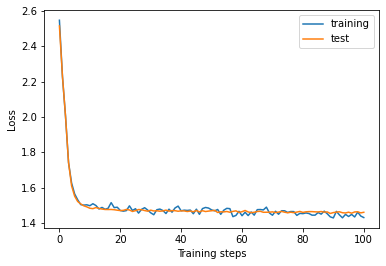

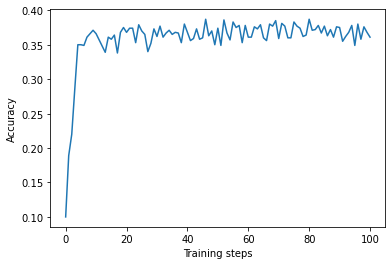

In [ ]:
import matplotlib.pyplot as plt

# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()

# epoch = 50 would've been enough